In [1]:
import keras
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.patches import ConnectionPatch
from matplotlib.cm import get_cmap
import seaborn as sns
import warnings

from sklearn.neighbors import KernelDensity
from sklearn.datasets import make_circles
import sklearn

from sklearn.model_selection import train_test_split

from matplotlib.colors import DivergingNorm
from tqdm.notebook import tqdm

from joblib import Parallel, delayed

from keras.datasets import cifar10

Using TensorFlow backend.


# Experiment Parameters

In [13]:
epochs = 100
width = 5

# Data Generation

# Construct & Train Network

In [28]:
def construct_network(X, y):
    network = keras.Sequential()
    network.add(keras.layers.Dense(width, input_shape = np.shape(X)[1:], activation = 'relu', use_bias=True, kernel_initializer = 'glorot_uniform'))
    network.add(keras.layers.Dense(width, activation = 'relu', use_bias=True, kernel_initializer = 'glorot_uniform'))
    network.add(keras.layers.Dense(width, activation = 'relu', use_bias=True, kernel_initializer = 'glorot_uniform'))
    network.add(keras.layers.Dense(len(np.unique(y)), activation = 'sigmoid', use_bias=True, kernel_initializer = 'glorot_uniform'))
    network.compile(loss = 'categorical_crossentropy', optimizer = keras.optimizers.Adam(3e-4), metrics = ['acc'])
    network.fit(
      X, 
      keras.utils.to_categorical(y), 
      epochs = epochs, 
      callbacks = [keras.callbacks.EarlyStopping(monitor = "loss", patience = 5, min_delta = 1e-3)],
      verbose = True
    )
    
    return network

    

## Keurnal Networks

In [29]:
def train_AKN(network, X, y, X_test, y_test):
    input_weights, second_weights, penultimate_weights, ultimate_weights = [network.layers[i].get_weights()[0] for i in {0, 1, 2, 3}]
    input_bias, second_bias, penultimate_bias, ultimate_bias = [network.layers[i].get_weights()[1] for i in {0, 1, 2, 3}]
    signed_second_layer_preactivations = np.sign(np.matmul(X, input_weights) + input_bias)
    signed_second_layer_activations = signed_second_layer_preactivations * (signed_second_layer_preactivations > 0).astype('int')
    signed_third_layer_preactivations = np.matmul(signed_second_layer_activations, second_weights) + second_bias
    signed_third_layer_activations = signed_third_layer_preactivations * (signed_third_layer_preactivations > 0).astype('int')
    signed_penultimate_preactivations = np.matmul(signed_third_layer_activations, penultimate_weights) + penultimate_bias
    signed_penultimate_activations = signed_penultimate_preactivations * (signed_penultimate_preactivations > 0).astype('int')
    signed_ultimate_preactivations = np.matmul(signed_penultimate_activations, ultimate_weights) + ultimate_bias


    #an array of all of the X-values of the class-wise means in each leaf
    polytope_means_X = []

    #an array of all of the y-values (i.e. class values) of the class-wise means in each leaf
    polytope_means_y = []

    #an array of all of the number of points that comprise the means in each leaf
    polytope_means_weight = []

    #an array of all of the average variances of the points in each leaf corresponding to 
    #a single class from the class-wise mean in that leaf
    polytope_means_var = []

    polytope_KDEs = []

    for polytope_value in np.unique(signed_ultimate_preactivations):
        for y_val in np.unique(y):
            idxs_in_polytope_of_class = np.where((y == y_val) & (signed_ultimate_preactivations == polytope_value)[:, 0])[0]
            if len(idxs_in_polytope_of_class) > 1:
                mean_X_in_polytope_of_class = np.mean(X[idxs_in_polytope_of_class], axis = 0)

                polytope_means_X.append(mean_X_in_polytope_of_class)
                #we already know the y value, so just append it 
                polytope_means_y.append(y_val)
                #compute the number of points in that leaf corresponding to that y value
                #and append to the aggregate array
                polytope_means_weight.append(len(idxs_in_polytope_of_class))
                #compute the distances of all the points in that leaf corresponding to that y value
                #from the mean X-value of the points in that leaf corresponding to that y value
                dists_in_polytope = np.sqrt(np.sum((X[idxs_in_polytope_of_class] - mean_X_in_polytope_of_class)**2, axis = 1))
                #compute the variance as the average distance of the class-wise points in that leaf 
                #and append to the aggregate array
                polytope_means_var.append(np.mean(dists_in_polytope))


    #convert to numpy array so we can easily refer to multiple sets of points as ra[idxs]
    polytope_means_y, polytope_means_X, polytope_means_weight = np.array(polytope_means_y), np.array(polytope_means_X), np.array(polytope_means_weight)
    #compute the bandwidth as the average variance across the class-wise leaf means, weighted
    #by the number of points
    bandwidth=np.average(polytope_means_var, weights = polytope_means_weight)

    #an array of all of the KDEs. Each KDE will be respondsible for computing the probability 
    #that a given set of inference points belongs to that class. Thus, we have separate KDEs 
    #for each class. The KDE at index i is the KDE that is responsible for computations on 
    #y_value = i
    KDEs = []
    #loop over the y values in the leaf means 
    for y_val in np.unique(polytope_means_y):
        #gather all of the leaf means corresponding to the given y value
        polytope_means_X_of_y_val = polytope_means_X[np.where(polytope_means_y == y_val)[0]]
        #father all of the weights corresponding to the given y value
        polytope_means_weight_of_y_val = polytope_means_weight[np.where(polytope_means_y == y_val)[0]]
        #train an sklearn KDE with a gaussian kernel with the bandwidth calculated above
        kde = KernelDensity(kernel='gaussian', bandwidth=bandwidth)
        #fit the KDE on the leaf means corresponding to the given y value, weighted by
        #the weights corresponding to the given y value
        kde.fit(X = polytope_means_X_of_y_val, sample_weight = polytope_means_weight_of_y_val)

        #append the KDE to the aggregate array
        KDEs.append(kde)
    
    return KDEs

In [30]:
X, y = sklearn.datasets.make_classification(n_samples = 10000,
                                            n_features = 3,
                                            n_informative = 3,
                                            n_redundant = 0,
                                            n_clusters_per_class = 3)
X, X_test, y, y_test = train_test_split(X, y)

In [31]:
KDE_accs = []
network_accs = []
dict_accs = []

KDE_stds = []
network_stds = []
n_ra = np.logspace(2, 4.5, num = 6, base= 10)
for n in tqdm(n_ra):
    KDE_accs_across_trials = []
    network_accs_across_trials = []
    for _ in tqdm(range(10)):
        
        random_indices = np.random.choice(len(X), int(n))
        X, y = X[random_indices], y[random_indices]
        
        
        network = construct_network(X, y)
        zero_sum_weights = False
        try:
            KDEs = train_AKN(network, X, y, X_test, y_test)
        except ZeroDivisionError:
            zero_sum_weights = True
        
        if not zero_sum_weights:
            y_proba = np.zeros((len(X_test), len(KDEs)))
            #loops over the KDEs (and thus, implicitly, the y-values)
            for y_val in range(len(KDEs)):
                #compute the (unnormalized) posterior for the KDE corresponding
                #to y_val. NOTE: we perform np.exp since the score_samples 
                #function returns the log of the probability of belonging to that 
                #class, so we must invert the log through an exponential
                y_proba[:, y_val] = np.exp(KDEs[y_val].score_samples(X_test) )

            KDE_accs_across_trials.append(np.mean(np.argmax(y_proba, axis = 1) == y_test))
            network_accs_across_trials.append(network.evaluate(X_test, keras.utils.to_categorical(y_test), verbose = False)[1])
            print("\tKDE: {}".format(KDE_accs_across_trials))
            print("\tNetwork: {}".format(network_accs_across_trials))
    KDE_accs.append(np.mean(KDE_accs_across_trials))
    network_accs.append(np.mean(network_accs_across_trials))
    
    KDE_stds.append(np.std(KDE_accs_across_trials))
    network_stds.append(np.std(network_accs_across_trials))
    print("KDE: {}".format(KDE_accs))
    print("Network: {}".format(network_accs))
    
    
    

Epoch 1/100
100/100 [==============================] - 1s 14ms/step - loss: 0.7307 - acc: 0.5700
Epoch 2/100
100/100 [==============================] - 0s 213us/step - loss: 0.7297 - acc: 0.5700
Epoch 3/100
100/100 [==============================] - 0s 212us/step - loss: 0.7288 - acc: 0.4700
Epoch 4/100
100/100 [==============================] - 0s 213us/step - loss: 0.7277 - acc: 0.4800
Epoch 5/100
100/100 [==============================] - 0s 212us/step - loss: 0.7268 - acc: 0.4900
Epoch 6/100
100/100 [==============================] - 0s 213us/step - loss: 0.7259 - acc: 0.4900
Epoch 7/100
100/100 [==============================] - 0s 212us/step - loss: 0.7250 - acc: 0.4900
Epoch 8/100
100/100 [==============================] - 0s 212us/step - loss: 0.7242 - acc: 0.4900
Epoch 9/100
100/100 [==============================] - 0s 215us/step - loss: 0.7232 - acc: 0.4900
Epoch 10/100
100/100 [==============================] - 0s 211us/step - loss: 0.7223 - acc: 0.4800
Epoch 11/100
100/100

100/100 [==============================] - 0s 212us/step - loss: 0.6760 - acc: 0.6200
Epoch 84/100
100/100 [==============================] - 0s 212us/step - loss: 0.6754 - acc: 0.6200
Epoch 85/100
100/100 [==============================] - 0s 213us/step - loss: 0.6748 - acc: 0.6200
Epoch 86/100
100/100 [==============================] - 0s 219us/step - loss: 0.6742 - acc: 0.6200
Epoch 87/100
100/100 [==============================] - 0s 221us/step - loss: 0.6735 - acc: 0.6200
Epoch 88/100
100/100 [==============================] - 0s 223us/step - loss: 0.6728 - acc: 0.6200
Epoch 89/100
100/100 [==============================] - 0s 215us/step - loss: 0.6720 - acc: 0.6200
Epoch 90/100
100/100 [==============================] - 0s 215us/step - loss: 0.6713 - acc: 0.6200
Epoch 91/100
100/100 [==============================] - 0s 218us/step - loss: 0.6705 - acc: 0.6200
Epoch 92/100
100/100 [==============================] - 0s 219us/step - loss: 0.6697 - acc: 0.6200
Epoch 93/100
100/100 [=

100/100 [==============================] - 0s 223us/step - loss: 0.6684 - acc: 0.5700
Epoch 66/100
100/100 [==============================] - 0s 221us/step - loss: 0.6679 - acc: 0.5700
Epoch 67/100
100/100 [==============================] - 0s 221us/step - loss: 0.6675 - acc: 0.5700
Epoch 68/100
100/100 [==============================] - 0s 222us/step - loss: 0.6670 - acc: 0.5700
Epoch 69/100
100/100 [==============================] - 0s 227us/step - loss: 0.6666 - acc: 0.5700
Epoch 70/100
100/100 [==============================] - 0s 221us/step - loss: 0.6661 - acc: 0.5700
Epoch 71/100
100/100 [==============================] - 0s 228us/step - loss: 0.6658 - acc: 0.5700
Epoch 72/100
100/100 [==============================] - 0s 223us/step - loss: 0.6653 - acc: 0.5700
Epoch 73/100
100/100 [==============================] - 0s 223us/step - loss: 0.6648 - acc: 0.5700
Epoch 74/100
100/100 [==============================] - 0s 225us/step - loss: 0.6644 - acc: 0.5700
Epoch 75/100
100/100 [=

100/100 [==============================] - 0s 223us/step - loss: 0.6496 - acc: 0.6700
Epoch 48/100
100/100 [==============================] - 0s 225us/step - loss: 0.6489 - acc: 0.6600
Epoch 49/100
100/100 [==============================] - 0s 225us/step - loss: 0.6484 - acc: 0.6600
Epoch 50/100
100/100 [==============================] - 0s 229us/step - loss: 0.6478 - acc: 0.6600
Epoch 51/100
100/100 [==============================] - 0s 225us/step - loss: 0.6473 - acc: 0.6600
Epoch 52/100
100/100 [==============================] - 0s 219us/step - loss: 0.6466 - acc: 0.6700
Epoch 53/100
100/100 [==============================] - 0s 228us/step - loss: 0.6461 - acc: 0.6700
Epoch 54/100
100/100 [==============================] - 0s 226us/step - loss: 0.6456 - acc: 0.6900
Epoch 55/100
100/100 [==============================] - 0s 226us/step - loss: 0.6450 - acc: 0.6900
Epoch 56/100
100/100 [==============================] - 0s 220us/step - loss: 0.6445 - acc: 0.6900
Epoch 57/100
100/100 [=

Epoch 29/100
100/100 [==============================] - 0s 228us/step - loss: 0.6992 - acc: 0.5400
Epoch 30/100
100/100 [==============================] - 0s 234us/step - loss: 0.6990 - acc: 0.5400
Epoch 31/100
100/100 [==============================] - 0s 238us/step - loss: 0.6987 - acc: 0.5400
Epoch 32/100
100/100 [==============================] - 0s 225us/step - loss: 0.6985 - acc: 0.5400
Epoch 33/100
100/100 [==============================] - 0s 231us/step - loss: 0.6983 - acc: 0.5400
Epoch 34/100
100/100 [==============================] - 0s 233us/step - loss: 0.6981 - acc: 0.5400
Epoch 35/100
100/100 [==============================] - 0s 231us/step - loss: 0.6979 - acc: 0.5400
Epoch 36/100
100/100 [==============================] - 0s 228us/step - loss: 0.6977 - acc: 0.5400
	KDE: [0.8636, 0.8548, 0.8132, 0.8572]
	Network: [0.5644000172615051, 0.504800021648407, 0.6620000004768372, 0.504800021648407]
Epoch 1/100
100/100 [==============================] - 2s 16ms/step - loss: 0.68

100/100 [==============================] - 0s 233us/step - loss: 0.5749 - acc: 0.8400
Epoch 75/100
100/100 [==============================] - 0s 233us/step - loss: 0.5726 - acc: 0.8400
Epoch 76/100
100/100 [==============================] - 0s 229us/step - loss: 0.5701 - acc: 0.8400
Epoch 77/100
100/100 [==============================] - 0s 227us/step - loss: 0.5677 - acc: 0.8400
Epoch 78/100
100/100 [==============================] - 0s 226us/step - loss: 0.5654 - acc: 0.8400
Epoch 79/100
100/100 [==============================] - 0s 229us/step - loss: 0.5631 - acc: 0.8400
Epoch 80/100
100/100 [==============================] - 0s 220us/step - loss: 0.5608 - acc: 0.8400
Epoch 81/100
100/100 [==============================] - 0s 219us/step - loss: 0.5583 - acc: 0.8400
Epoch 82/100
100/100 [==============================] - 0s 222us/step - loss: 0.5560 - acc: 0.8400
Epoch 83/100
100/100 [==============================] - 0s 225us/step - loss: 0.5537 - acc: 0.8400
Epoch 84/100
100/100 [=

100/100 [==============================] - 0s 222us/step - loss: 0.6149 - acc: 0.8600
Epoch 56/100
100/100 [==============================] - 0s 220us/step - loss: 0.6118 - acc: 0.8600
Epoch 57/100
100/100 [==============================] - 0s 217us/step - loss: 0.6085 - acc: 0.8600
Epoch 58/100
100/100 [==============================] - 0s 216us/step - loss: 0.6052 - acc: 0.8600
Epoch 59/100
100/100 [==============================] - 0s 218us/step - loss: 0.6018 - acc: 0.8600
Epoch 60/100
100/100 [==============================] - 0s 217us/step - loss: 0.5984 - acc: 0.8600
Epoch 61/100
100/100 [==============================] - 0s 222us/step - loss: 0.5949 - acc: 0.8600
Epoch 62/100
100/100 [==============================] - 0s 217us/step - loss: 0.5914 - acc: 0.8600
Epoch 63/100
100/100 [==============================] - 0s 219us/step - loss: 0.5880 - acc: 0.8600
Epoch 64/100
100/100 [==============================] - 0s 219us/step - loss: 0.5845 - acc: 0.8700
Epoch 65/100
100/100 [=

100/100 [==============================] - 0s 223us/step - loss: 0.7472 - acc: 0.3400
Epoch 37/100
100/100 [==============================] - 0s 219us/step - loss: 0.7455 - acc: 0.3400
Epoch 38/100
100/100 [==============================] - 0s 220us/step - loss: 0.7440 - acc: 0.3400
Epoch 39/100
100/100 [==============================] - 0s 218us/step - loss: 0.7425 - acc: 0.3400
Epoch 40/100
100/100 [==============================] - 0s 222us/step - loss: 0.7411 - acc: 0.3400
Epoch 41/100
100/100 [==============================] - 0s 221us/step - loss: 0.7394 - acc: 0.3400
Epoch 42/100
100/100 [==============================] - 0s 222us/step - loss: 0.7380 - acc: 0.3400
Epoch 43/100
100/100 [==============================] - 0s 217us/step - loss: 0.7366 - acc: 0.3400
Epoch 44/100
100/100 [==============================] - 0s 221us/step - loss: 0.7352 - acc: 0.3400
Epoch 45/100
100/100 [==============================] - 0s 219us/step - loss: 0.7338 - acc: 0.3400
Epoch 46/100
100/100 [=

100/100 [==============================] - 0s 218us/step - loss: 0.7125 - acc: 0.3900
Epoch 17/100
100/100 [==============================] - 0s 218us/step - loss: 0.7119 - acc: 0.4600
Epoch 18/100
100/100 [==============================] - 0s 218us/step - loss: 0.7112 - acc: 0.4800
Epoch 19/100
100/100 [==============================] - 0s 219us/step - loss: 0.7106 - acc: 0.4800
Epoch 20/100
100/100 [==============================] - 0s 216us/step - loss: 0.7100 - acc: 0.4800
Epoch 21/100
100/100 [==============================] - 0s 220us/step - loss: 0.7095 - acc: 0.4800
Epoch 22/100
100/100 [==============================] - 0s 219us/step - loss: 0.7089 - acc: 0.4800
Epoch 23/100
100/100 [==============================] - 0s 219us/step - loss: 0.7083 - acc: 0.4800
Epoch 24/100
100/100 [==============================] - 0s 218us/step - loss: 0.7079 - acc: 0.4800
Epoch 25/100
100/100 [==============================] - 0s 224us/step - loss: 0.7074 - acc: 0.4800
Epoch 26/100
100/100 [=

100/100 [==============================] - 0s 219us/step - loss: 0.6623 - acc: 0.7400
Epoch 99/100
100/100 [==============================] - 0s 221us/step - loss: 0.6606 - acc: 0.7600
Epoch 100/100
100/100 [==============================] - 0s 222us/step - loss: 0.6591 - acc: 0.7700
	KDE: [0.8636, 0.8548, 0.8132, 0.8572, 0.8088, 0.7616, 0.8064, 0.7204]
	Network: [0.5644000172615051, 0.504800021648407, 0.6620000004768372, 0.504800021648407, 0.8068000078201294, 0.734000027179718, 0.4399999976158142, 0.6299999952316284]
Epoch 1/100
100/100 [==============================] - 2s 16ms/step - loss: 0.6998 - acc: 0.4700
Epoch 2/100
100/100 [==============================] - 0s 222us/step - loss: 0.6972 - acc: 0.4700
Epoch 3/100
100/100 [==============================] - 0s 220us/step - loss: 0.6948 - acc: 0.4700
Epoch 4/100
100/100 [==============================] - 0s 226us/step - loss: 0.6925 - acc: 0.4700
Epoch 5/100
100/100 [==============================] - 0s 228us/step - loss: 0.6901 -

100/100 [==============================] - 0s 228us/step - loss: 0.5510 - acc: 0.8600
Epoch 79/100
100/100 [==============================] - 0s 223us/step - loss: 0.5491 - acc: 0.8600
Epoch 80/100
100/100 [==============================] - 0s 222us/step - loss: 0.5472 - acc: 0.8600
Epoch 81/100
100/100 [==============================] - 0s 221us/step - loss: 0.5452 - acc: 0.8600
Epoch 82/100
100/100 [==============================] - 0s 222us/step - loss: 0.5433 - acc: 0.8600
Epoch 83/100
100/100 [==============================] - 0s 218us/step - loss: 0.5413 - acc: 0.9200
Epoch 84/100
100/100 [==============================] - 0s 224us/step - loss: 0.5392 - acc: 0.9200
Epoch 85/100
100/100 [==============================] - 0s 220us/step - loss: 0.5370 - acc: 0.9200
Epoch 86/100
100/100 [==============================] - 0s 223us/step - loss: 0.5349 - acc: 0.9200
Epoch 87/100
100/100 [==============================] - 0s 221us/step - loss: 0.5328 - acc: 0.9200
Epoch 88/100
100/100 [=

100/100 [==============================] - 0s 218us/step - loss: 0.5903 - acc: 0.7600
Epoch 59/100
100/100 [==============================] - 0s 223us/step - loss: 0.5889 - acc: 0.7600
Epoch 60/100
100/100 [==============================] - 0s 222us/step - loss: 0.5876 - acc: 0.7600
Epoch 61/100
100/100 [==============================] - 0s 220us/step - loss: 0.5863 - acc: 0.7600
Epoch 62/100
100/100 [==============================] - 0s 221us/step - loss: 0.5849 - acc: 0.7600
Epoch 63/100
100/100 [==============================] - 0s 223us/step - loss: 0.5835 - acc: 0.7600
Epoch 64/100
100/100 [==============================] - 0s 220us/step - loss: 0.5819 - acc: 0.7600
Epoch 65/100
100/100 [==============================] - 0s 224us/step - loss: 0.5804 - acc: 0.7600
Epoch 66/100
100/100 [==============================] - 0s 222us/step - loss: 0.5791 - acc: 0.7600
Epoch 67/100
100/100 [==============================] - 0s 225us/step - loss: 0.5775 - acc: 0.7600
Epoch 68/100
100/100 [=

Epoch 1/100
316/316 [==============================] - 2s 5ms/step - loss: 0.6949 - acc: 0.5253
Epoch 2/100
316/316 [==============================] - 0s 170us/step - loss: 0.6944 - acc: 0.5854
Epoch 3/100
316/316 [==============================] - 0s 171us/step - loss: 0.6939 - acc: 0.6203
Epoch 4/100
316/316 [==============================] - 0s 171us/step - loss: 0.6935 - acc: 0.6361
Epoch 5/100
316/316 [==============================] - 0s 173us/step - loss: 0.6930 - acc: 0.6044
Epoch 6/100
316/316 [==============================] - 0s 170us/step - loss: 0.6926 - acc: 0.6044
Epoch 7/100
316/316 [==============================] - 0s 171us/step - loss: 0.6921 - acc: 0.7057
Epoch 8/100
316/316 [==============================] - 0s 170us/step - loss: 0.6917 - acc: 0.7057
Epoch 9/100
316/316 [==============================] - 0s 171us/step - loss: 0.6912 - acc: 0.6741
Epoch 10/100
316/316 [==============================] - 0s 171us/step - loss: 0.6907 - acc: 0.6044
Epoch 11/100
316/316 

316/316 [==============================] - 0s 170us/step - loss: 0.3179 - acc: 0.9177
Epoch 84/100
316/316 [==============================] - 0s 170us/step - loss: 0.3128 - acc: 0.9177
Epoch 85/100
316/316 [==============================] - 0s 170us/step - loss: 0.3080 - acc: 0.9177
Epoch 86/100
316/316 [==============================] - 0s 171us/step - loss: 0.3032 - acc: 0.9177
Epoch 87/100
316/316 [==============================] - 0s 171us/step - loss: 0.2987 - acc: 0.9177
Epoch 88/100
316/316 [==============================] - 0s 169us/step - loss: 0.2936 - acc: 0.9177
Epoch 89/100
316/316 [==============================] - 0s 170us/step - loss: 0.2878 - acc: 0.9177
Epoch 90/100
316/316 [==============================] - 0s 170us/step - loss: 0.2822 - acc: 0.9304
Epoch 91/100
316/316 [==============================] - 0s 170us/step - loss: 0.2766 - acc: 0.9842
Epoch 92/100
316/316 [==============================] - 0s 170us/step - loss: 0.2715 - acc: 0.9842
Epoch 93/100
316/316 [=

316/316 [==============================] - 0s 173us/step - loss: 0.2987 - acc: 0.9557
Epoch 66/100
316/316 [==============================] - 0s 173us/step - loss: 0.2926 - acc: 0.9842
Epoch 67/100
316/316 [==============================] - 0s 174us/step - loss: 0.2859 - acc: 0.9842
Epoch 68/100
316/316 [==============================] - 0s 174us/step - loss: 0.2792 - acc: 0.9842
Epoch 69/100
316/316 [==============================] - 0s 173us/step - loss: 0.2719 - acc: 0.9842
Epoch 70/100
316/316 [==============================] - 0s 172us/step - loss: 0.2653 - acc: 0.9842
Epoch 71/100
316/316 [==============================] - 0s 174us/step - loss: 0.2586 - acc: 0.9842
Epoch 72/100
316/316 [==============================] - 0s 174us/step - loss: 0.2524 - acc: 0.9842
Epoch 73/100
316/316 [==============================] - 0s 174us/step - loss: 0.2462 - acc: 0.9842
Epoch 74/100
316/316 [==============================] - 0s 174us/step - loss: 0.2402 - acc: 0.9842
Epoch 75/100
316/316 [=

316/316 [==============================] - 0s 173us/step - loss: 0.4810 - acc: 0.7310
Epoch 48/100
316/316 [==============================] - 0s 171us/step - loss: 0.4761 - acc: 0.7310
Epoch 49/100
316/316 [==============================] - 0s 173us/step - loss: 0.4709 - acc: 0.7310
Epoch 50/100
316/316 [==============================] - 0s 174us/step - loss: 0.4656 - acc: 0.7310
Epoch 51/100
316/316 [==============================] - 0s 173us/step - loss: 0.4603 - acc: 0.7310
Epoch 52/100
316/316 [==============================] - 0s 174us/step - loss: 0.4548 - acc: 0.7310
Epoch 53/100
316/316 [==============================] - 0s 175us/step - loss: 0.4495 - acc: 0.8101
Epoch 54/100
316/316 [==============================] - 0s 174us/step - loss: 0.4442 - acc: 0.9019
Epoch 55/100
316/316 [==============================] - 0s 173us/step - loss: 0.4388 - acc: 0.9399
Epoch 56/100
316/316 [==============================] - 0s 173us/step - loss: 0.4334 - acc: 0.9399
Epoch 57/100
316/316 [=

Epoch 29/100
316/316 [==============================] - 0s 174us/step - loss: 0.6621 - acc: 0.5063
Epoch 30/100
316/316 [==============================] - 0s 175us/step - loss: 0.6582 - acc: 0.5063
Epoch 31/100
316/316 [==============================] - 0s 172us/step - loss: 0.6540 - acc: 0.5063
Epoch 32/100
316/316 [==============================] - 0s 175us/step - loss: 0.6495 - acc: 0.5063
Epoch 33/100
316/316 [==============================] - 0s 177us/step - loss: 0.6444 - acc: 0.5063
Epoch 34/100
316/316 [==============================] - 0s 173us/step - loss: 0.6394 - acc: 0.5063
Epoch 35/100
316/316 [==============================] - 0s 174us/step - loss: 0.6335 - acc: 0.5063
Epoch 36/100
316/316 [==============================] - 0s 174us/step - loss: 0.6276 - acc: 0.5063
Epoch 37/100
316/316 [==============================] - 0s 174us/step - loss: 0.6212 - acc: 0.6456
Epoch 38/100
316/316 [==============================] - 0s 174us/step - loss: 0.6146 - acc: 0.6804
Epoch 39/1

316/316 [==============================] - 0s 179us/step - loss: 0.6651 - acc: 0.8101
Epoch 11/100
316/316 [==============================] - 0s 177us/step - loss: 0.6618 - acc: 0.8101
Epoch 12/100
316/316 [==============================] - 0s 177us/step - loss: 0.6583 - acc: 0.9177
Epoch 13/100
316/316 [==============================] - 0s 180us/step - loss: 0.6547 - acc: 0.9842
Epoch 14/100
316/316 [==============================] - 0s 177us/step - loss: 0.6509 - acc: 0.9842
Epoch 15/100
316/316 [==============================] - 0s 178us/step - loss: 0.6469 - acc: 0.9842
Epoch 16/100
316/316 [==============================] - 0s 178us/step - loss: 0.6427 - acc: 0.9842
Epoch 17/100
316/316 [==============================] - 0s 179us/step - loss: 0.6383 - acc: 0.9842
Epoch 18/100
316/316 [==============================] - 0s 178us/step - loss: 0.6337 - acc: 0.9842
Epoch 19/100
316/316 [==============================] - 0s 177us/step - loss: 0.6288 - acc: 0.9842
Epoch 20/100
316/316 [=

316/316 [==============================] - 0s 176us/step - loss: 0.1210 - acc: 0.9842
Epoch 93/100
316/316 [==============================] - 0s 174us/step - loss: 0.1185 - acc: 0.9842
Epoch 94/100
316/316 [==============================] - 0s 175us/step - loss: 0.1161 - acc: 0.9842
Epoch 95/100
316/316 [==============================] - 0s 174us/step - loss: 0.1138 - acc: 0.9842
Epoch 96/100
316/316 [==============================] - 0s 174us/step - loss: 0.1115 - acc: 0.9842
Epoch 97/100
316/316 [==============================] - 0s 175us/step - loss: 0.1093 - acc: 0.9842
Epoch 98/100
316/316 [==============================] - 0s 176us/step - loss: 0.1073 - acc: 0.9842
Epoch 99/100
316/316 [==============================] - 0s 175us/step - loss: 0.1053 - acc: 0.9842
Epoch 100/100
316/316 [==============================] - 0s 176us/step - loss: 0.1033 - acc: 0.9842
	KDE: [0.8076, 0.818, 0.7308, 0.7984, 0.8172]
	Network: [0.6891999840736389, 0.6571999788284302, 0.6764000058174133, 0.74

316/316 [==============================] - 0s 176us/step - loss: 0.3336 - acc: 0.9367
Epoch 52/100
316/316 [==============================] - 0s 177us/step - loss: 0.3273 - acc: 0.9367
Epoch 53/100
316/316 [==============================] - 0s 177us/step - loss: 0.3214 - acc: 0.9367
Epoch 54/100
316/316 [==============================] - 0s 179us/step - loss: 0.3152 - acc: 0.9367
Epoch 55/100
316/316 [==============================] - 0s 177us/step - loss: 0.3094 - acc: 0.9367
Epoch 56/100
316/316 [==============================] - 0s 179us/step - loss: 0.3033 - acc: 0.9367
Epoch 57/100
316/316 [==============================] - 0s 179us/step - loss: 0.2975 - acc: 0.9367
Epoch 58/100
316/316 [==============================] - 0s 176us/step - loss: 0.2913 - acc: 0.9810
Epoch 59/100
316/316 [==============================] - 0s 177us/step - loss: 0.2855 - acc: 0.9810
Epoch 60/100
316/316 [==============================] - 0s 177us/step - loss: 0.2794 - acc: 0.9810
Epoch 61/100
316/316 [=

316/316 [==============================] - 0s 181us/step - loss: 0.5478 - acc: 0.9367
Epoch 32/100
316/316 [==============================] - 0s 177us/step - loss: 0.5420 - acc: 0.9367
Epoch 33/100
316/316 [==============================] - 0s 177us/step - loss: 0.5363 - acc: 0.9367
Epoch 34/100
316/316 [==============================] - 0s 178us/step - loss: 0.5303 - acc: 0.9367
Epoch 35/100
316/316 [==============================] - 0s 177us/step - loss: 0.5243 - acc: 0.9367
Epoch 36/100
316/316 [==============================] - 0s 179us/step - loss: 0.5181 - acc: 0.9367
Epoch 37/100
316/316 [==============================] - 0s 177us/step - loss: 0.5118 - acc: 0.9367
Epoch 38/100
316/316 [==============================] - 0s 179us/step - loss: 0.5053 - acc: 0.9367
Epoch 39/100
316/316 [==============================] - 0s 178us/step - loss: 0.4988 - acc: 0.9367
Epoch 40/100
316/316 [==============================] - 0s 179us/step - loss: 0.4921 - acc: 0.9367
Epoch 41/100
316/316 [=

316/316 [==============================] - 0s 178us/step - loss: 0.6189 - acc: 0.8418
Epoch 12/100
316/316 [==============================] - 0s 180us/step - loss: 0.6123 - acc: 0.8418
Epoch 13/100
316/316 [==============================] - 0s 178us/step - loss: 0.6055 - acc: 0.8576
Epoch 14/100
316/316 [==============================] - 0s 180us/step - loss: 0.5986 - acc: 0.8734
Epoch 15/100
316/316 [==============================] - 0s 178us/step - loss: 0.5914 - acc: 0.8734
Epoch 16/100
316/316 [==============================] - 0s 180us/step - loss: 0.5842 - acc: 0.8734
Epoch 17/100
316/316 [==============================] - 0s 178us/step - loss: 0.5774 - acc: 0.8734
Epoch 18/100
316/316 [==============================] - 0s 179us/step - loss: 0.5706 - acc: 0.8734
Epoch 19/100
316/316 [==============================] - 0s 179us/step - loss: 0.5639 - acc: 0.8734
Epoch 20/100
316/316 [==============================] - 0s 179us/step - loss: 0.5570 - acc: 0.8734
Epoch 21/100
316/316 [=

316/316 [==============================] - 0s 179us/step - loss: 0.1818 - acc: 0.9589
Epoch 94/100
316/316 [==============================] - 0s 177us/step - loss: 0.1807 - acc: 0.9589
Epoch 95/100
316/316 [==============================] - 0s 180us/step - loss: 0.1796 - acc: 0.9589
Epoch 96/100
316/316 [==============================] - 0s 178us/step - loss: 0.1785 - acc: 0.9589
Epoch 97/100
316/316 [==============================] - 0s 179us/step - loss: 0.1775 - acc: 0.9589
Epoch 98/100
316/316 [==============================] - 0s 179us/step - loss: 0.1764 - acc: 0.9589
Epoch 99/100
316/316 [==============================] - 0s 179us/step - loss: 0.1755 - acc: 0.9589
Epoch 100/100
316/316 [==============================] - 0s 178us/step - loss: 0.1746 - acc: 0.9589
	KDE: [0.8076, 0.818, 0.7308, 0.7984, 0.8172, 0.7564, 0.8508, 0.7596, 0.7388]
	Network: [0.6891999840736389, 0.6571999788284302, 0.6764000058174133, 0.7400000095367432, 0.7379999756813049, 0.504800021648407, 0.7364000082

316/316 [==============================] - 0s 178us/step - loss: 0.3501 - acc: 0.8354
Epoch 74/100
316/316 [==============================] - 0s 178us/step - loss: 0.3450 - acc: 0.8354
Epoch 75/100
316/316 [==============================] - 0s 178us/step - loss: 0.3401 - acc: 0.8354
Epoch 76/100
316/316 [==============================] - 0s 178us/step - loss: 0.3350 - acc: 0.8354
Epoch 77/100
316/316 [==============================] - 0s 178us/step - loss: 0.3300 - acc: 0.8354
Epoch 78/100
316/316 [==============================] - 0s 180us/step - loss: 0.3252 - acc: 0.8797
Epoch 79/100
316/316 [==============================] - 0s 179us/step - loss: 0.3204 - acc: 0.9209
Epoch 80/100
316/316 [==============================] - 0s 177us/step - loss: 0.3158 - acc: 0.9209
Epoch 81/100
316/316 [==============================] - 0s 178us/step - loss: 0.3111 - acc: 0.9209
Epoch 82/100
316/316 [==============================] - 0s 178us/step - loss: 0.3066 - acc: 0.9209
Epoch 83/100
316/316 [=

Epoch 1/100
1000/1000 [==============================] - 2s 2ms/step - loss: 0.7046 - acc: 0.4000
Epoch 2/100
1000/1000 [==============================] - 0s 184us/step - loss: 0.6949 - acc: 0.4030
Epoch 3/100
1000/1000 [==============================] - 0s 184us/step - loss: 0.6863 - acc: 0.4030
Epoch 4/100
1000/1000 [==============================] - 0s 185us/step - loss: 0.6782 - acc: 0.4470
Epoch 5/100
1000/1000 [==============================] - 0s 183us/step - loss: 0.6705 - acc: 0.4970
Epoch 6/100
1000/1000 [==============================] - 0s 182us/step - loss: 0.6632 - acc: 0.5750
Epoch 7/100
1000/1000 [==============================] - 0s 184us/step - loss: 0.6575 - acc: 0.6280
Epoch 8/100
1000/1000 [==============================] - 0s 184us/step - loss: 0.6529 - acc: 0.6280
Epoch 9/100
1000/1000 [==============================] - 0s 184us/step - loss: 0.6485 - acc: 0.6280
Epoch 10/100
1000/1000 [==============================] - 0s 185us/step - loss: 0.6439 - acc: 0.6280
E

1000/1000 [==============================] - 0s 184us/step - loss: 0.1287 - acc: 0.9600
Epoch 83/100
1000/1000 [==============================] - 0s 186us/step - loss: 0.1266 - acc: 0.9600
Epoch 84/100
1000/1000 [==============================] - 0s 187us/step - loss: 0.1246 - acc: 0.9600
Epoch 85/100
1000/1000 [==============================] - 0s 186us/step - loss: 0.1226 - acc: 0.9600
Epoch 86/100
1000/1000 [==============================] - 0s 186us/step - loss: 0.1206 - acc: 0.9600
Epoch 87/100
1000/1000 [==============================] - 0s 184us/step - loss: 0.1187 - acc: 0.9600
Epoch 88/100
1000/1000 [==============================] - 0s 185us/step - loss: 0.1167 - acc: 0.9600
Epoch 89/100
1000/1000 [==============================] - 0s 184us/step - loss: 0.1147 - acc: 0.9600
Epoch 90/100
1000/1000 [==============================] - 0s 184us/step - loss: 0.1128 - acc: 0.9600
Epoch 91/100
1000/1000 [==============================] - 0s 184us/step - loss: 0.1108 - acc: 0.9600
Epo

1000/1000 [==============================] - 0s 193us/step - loss: 0.0996 - acc: 0.9160
Epoch 63/100
1000/1000 [==============================] - 0s 192us/step - loss: 0.0980 - acc: 0.9250
Epoch 64/100
1000/1000 [==============================] - 0s 191us/step - loss: 0.0963 - acc: 0.9480
Epoch 65/100
1000/1000 [==============================] - 0s 192us/step - loss: 0.0950 - acc: 0.9330
Epoch 66/100
1000/1000 [==============================] - 0s 193us/step - loss: 0.0924 - acc: 0.9480
Epoch 67/100
1000/1000 [==============================] - 0s 191us/step - loss: 0.0913 - acc: 0.9480
Epoch 68/100
1000/1000 [==============================] - 0s 191us/step - loss: 0.0899 - acc: 0.9480
Epoch 69/100
1000/1000 [==============================] - 0s 191us/step - loss: 0.0881 - acc: 0.9480
Epoch 70/100
1000/1000 [==============================] - 0s 191us/step - loss: 0.0869 - acc: 0.9880
Epoch 71/100
1000/1000 [==============================] - 0s 191us/step - loss: 0.0856 - acc: 0.9670
Epo

1000/1000 [==============================] - 0s 190us/step - loss: 0.2530 - acc: 0.9500
Epoch 43/100
1000/1000 [==============================] - 0s 192us/step - loss: 0.2479 - acc: 0.9500
Epoch 44/100
1000/1000 [==============================] - 0s 193us/step - loss: 0.2430 - acc: 0.9500
Epoch 45/100
1000/1000 [==============================] - 0s 193us/step - loss: 0.2383 - acc: 0.9500
Epoch 46/100
1000/1000 [==============================] - 0s 191us/step - loss: 0.2336 - acc: 0.9500
Epoch 47/100
1000/1000 [==============================] - 0s 190us/step - loss: 0.2292 - acc: 0.9500
Epoch 48/100
1000/1000 [==============================] - 0s 192us/step - loss: 0.2249 - acc: 0.9500
Epoch 49/100
1000/1000 [==============================] - 0s 192us/step - loss: 0.2208 - acc: 0.9500
Epoch 50/100
1000/1000 [==============================] - 0s 194us/step - loss: 0.2168 - acc: 0.9500
Epoch 51/100
1000/1000 [==============================] - 0s 195us/step - loss: 0.2128 - acc: 0.9500
Epo

1000/1000 [==============================] - 0s 191us/step - loss: 0.5576 - acc: 0.9580
Epoch 23/100
1000/1000 [==============================] - 0s 191us/step - loss: 0.5451 - acc: 0.9580
Epoch 24/100
1000/1000 [==============================] - 0s 190us/step - loss: 0.5330 - acc: 0.9580
Epoch 25/100
1000/1000 [==============================] - 0s 191us/step - loss: 0.5210 - acc: 0.9580
Epoch 26/100
1000/1000 [==============================] - 0s 190us/step - loss: 0.5092 - acc: 0.9580
Epoch 27/100
1000/1000 [==============================] - 0s 191us/step - loss: 0.4983 - acc: 0.9580
Epoch 28/100
1000/1000 [==============================] - 0s 191us/step - loss: 0.4878 - acc: 0.9580
Epoch 29/100
1000/1000 [==============================] - 0s 190us/step - loss: 0.4776 - acc: 0.9580
Epoch 30/100
1000/1000 [==============================] - 0s 191us/step - loss: 0.4679 - acc: 0.9580
Epoch 31/100
1000/1000 [==============================] - 0s 191us/step - loss: 0.4588 - acc: 0.9580
Epo

Epoch 2/100
1000/1000 [==============================] - 0s 197us/step - loss: 0.6393 - acc: 0.6770
Epoch 3/100
1000/1000 [==============================] - 0s 198us/step - loss: 0.6243 - acc: 0.8290
Epoch 4/100
1000/1000 [==============================] - 0s 199us/step - loss: 0.6112 - acc: 0.8680
Epoch 5/100
1000/1000 [==============================] - 0s 198us/step - loss: 0.5971 - acc: 0.9550
Epoch 6/100
1000/1000 [==============================] - 0s 199us/step - loss: 0.5814 - acc: 0.9550
Epoch 7/100
1000/1000 [==============================] - 0s 198us/step - loss: 0.5645 - acc: 0.9550
Epoch 8/100
1000/1000 [==============================] - 0s 196us/step - loss: 0.5479 - acc: 0.9550
Epoch 9/100
1000/1000 [==============================] - 0s 199us/step - loss: 0.5304 - acc: 0.9550
Epoch 10/100
1000/1000 [==============================] - 0s 197us/step - loss: 0.5116 - acc: 0.9550
Epoch 11/100
1000/1000 [==============================] - 0s 198us/step - loss: 0.4920 - acc: 0.955

1000/1000 [==============================] - 0s 190us/step - loss: 0.1219 - acc: 0.9550
Epoch 84/100
1000/1000 [==============================] - 0s 189us/step - loss: 0.1211 - acc: 0.9550
Epoch 85/100
1000/1000 [==============================] - 0s 190us/step - loss: 0.1204 - acc: 0.9550
Epoch 86/100
1000/1000 [==============================] - 0s 190us/step - loss: 0.1198 - acc: 0.9550
Epoch 87/100
1000/1000 [==============================] - 0s 191us/step - loss: 0.1191 - acc: 0.9550
Epoch 88/100
1000/1000 [==============================] - 0s 189us/step - loss: 0.1183 - acc: 0.9550
Epoch 89/100
1000/1000 [==============================] - 0s 190us/step - loss: 0.1177 - acc: 0.9550
Epoch 90/100
1000/1000 [==============================] - 0s 189us/step - loss: 0.1169 - acc: 0.9550
Epoch 91/100
1000/1000 [==============================] - 0s 189us/step - loss: 0.1163 - acc: 0.9550
Epoch 92/100
1000/1000 [==============================] - 0s 190us/step - loss: 0.1155 - acc: 0.9550
Epo

1000/1000 [==============================] - 0s 190us/step - loss: 0.0774 - acc: 1.0000
Epoch 63/100
1000/1000 [==============================] - 0s 192us/step - loss: 0.0738 - acc: 1.0000
Epoch 64/100
1000/1000 [==============================] - 0s 190us/step - loss: 0.0705 - acc: 1.0000
Epoch 65/100
1000/1000 [==============================] - 0s 191us/step - loss: 0.0673 - acc: 1.0000
Epoch 66/100
1000/1000 [==============================] - 0s 191us/step - loss: 0.0644 - acc: 1.0000
Epoch 67/100
1000/1000 [==============================] - 0s 192us/step - loss: 0.0617 - acc: 1.0000
Epoch 68/100
1000/1000 [==============================] - 0s 192us/step - loss: 0.0591 - acc: 1.0000
Epoch 69/100
1000/1000 [==============================] - 0s 190us/step - loss: 0.0566 - acc: 1.0000
Epoch 70/100
1000/1000 [==============================] - 0s 192us/step - loss: 0.0543 - acc: 1.0000
Epoch 71/100
1000/1000 [==============================] - 0s 192us/step - loss: 0.0521 - acc: 1.0000
Epo

1000/1000 [==============================] - 0s 194us/step - loss: 0.3499 - acc: 1.0000
Epoch 42/100
1000/1000 [==============================] - 0s 194us/step - loss: 0.3449 - acc: 1.0000
Epoch 43/100
1000/1000 [==============================] - 0s 195us/step - loss: 0.3403 - acc: 1.0000
Epoch 44/100
1000/1000 [==============================] - 0s 195us/step - loss: 0.3359 - acc: 1.0000
Epoch 45/100
1000/1000 [==============================] - 0s 193us/step - loss: 0.3317 - acc: 1.0000
Epoch 46/100
1000/1000 [==============================] - 0s 194us/step - loss: 0.3277 - acc: 1.0000
Epoch 47/100
1000/1000 [==============================] - 0s 194us/step - loss: 0.3240 - acc: 1.0000
Epoch 48/100
1000/1000 [==============================] - 0s 193us/step - loss: 0.3204 - acc: 1.0000
Epoch 49/100
1000/1000 [==============================] - 0s 194us/step - loss: 0.3170 - acc: 1.0000
Epoch 50/100
1000/1000 [==============================] - 0s 194us/step - loss: 0.3137 - acc: 1.0000
Epo

1000/1000 [==============================] - 0s 192us/step - loss: 0.3238 - acc: 0.8430
Epoch 21/100
1000/1000 [==============================] - 0s 192us/step - loss: 0.3097 - acc: 0.8430
Epoch 22/100
1000/1000 [==============================] - 0s 194us/step - loss: 0.2969 - acc: 0.8430
Epoch 23/100
1000/1000 [==============================] - 0s 193us/step - loss: 0.2856 - acc: 0.8430
Epoch 24/100
1000/1000 [==============================] - 0s 193us/step - loss: 0.2757 - acc: 0.8430
Epoch 25/100
1000/1000 [==============================] - 0s 194us/step - loss: 0.2669 - acc: 0.8430
Epoch 26/100
1000/1000 [==============================] - 0s 194us/step - loss: 0.2590 - acc: 0.8430
Epoch 27/100
1000/1000 [==============================] - 0s 192us/step - loss: 0.2516 - acc: 0.8430
Epoch 28/100
1000/1000 [==============================] - 0s 194us/step - loss: 0.2449 - acc: 0.8430
Epoch 29/100
1000/1000 [==============================] - 0s 193us/step - loss: 0.2391 - acc: 0.8430
Epo

Epoch 1/100
1000/1000 [==============================] - 2s 2ms/step - loss: 0.7663 - acc: 0.4510
Epoch 2/100
1000/1000 [==============================] - 0s 190us/step - loss: 0.7468 - acc: 0.4510
Epoch 3/100
1000/1000 [==============================] - 0s 189us/step - loss: 0.7302 - acc: 0.4510
Epoch 4/100
1000/1000 [==============================] - 0s 191us/step - loss: 0.7153 - acc: 0.4510
Epoch 5/100
1000/1000 [==============================] - 0s 190us/step - loss: 0.7014 - acc: 0.5000
Epoch 6/100
1000/1000 [==============================] - 0s 190us/step - loss: 0.6877 - acc: 0.5190
Epoch 7/100
1000/1000 [==============================] - 0s 191us/step - loss: 0.6740 - acc: 0.5260
Epoch 8/100
1000/1000 [==============================] - 0s 191us/step - loss: 0.6602 - acc: 0.5710
Epoch 9/100
1000/1000 [==============================] - 0s 190us/step - loss: 0.6467 - acc: 0.6880
Epoch 10/100
1000/1000 [==============================] - 0s 190us/step - loss: 0.6320 - acc: 0.7060
E

1000/1000 [==============================] - 0s 191us/step - loss: 0.0955 - acc: 0.9590
Epoch 83/100
1000/1000 [==============================] - 0s 193us/step - loss: 0.0930 - acc: 0.9590
Epoch 84/100
1000/1000 [==============================] - 0s 193us/step - loss: 0.0904 - acc: 0.9590
Epoch 85/100
1000/1000 [==============================] - 0s 193us/step - loss: 0.0878 - acc: 0.9590
Epoch 86/100
1000/1000 [==============================] - 0s 193us/step - loss: 0.0853 - acc: 0.9590
Epoch 87/100
1000/1000 [==============================] - 0s 193us/step - loss: 0.0828 - acc: 0.9590
Epoch 88/100
1000/1000 [==============================] - 0s 192us/step - loss: 0.0804 - acc: 0.9590
Epoch 89/100
1000/1000 [==============================] - 0s 191us/step - loss: 0.0780 - acc: 0.9650
Epoch 90/100
1000/1000 [==============================] - 0s 191us/step - loss: 0.0757 - acc: 0.9720
Epoch 91/100
1000/1000 [==============================] - 0s 192us/step - loss: 0.0733 - acc: 1.0000
Epo

1000/1000 [==============================] - 0s 194us/step - loss: 0.2154 - acc: 0.9560
Epoch 61/100
1000/1000 [==============================] - 0s 194us/step - loss: 0.2122 - acc: 0.9560
Epoch 62/100
1000/1000 [==============================] - 0s 193us/step - loss: 0.2091 - acc: 0.9560
Epoch 63/100
1000/1000 [==============================] - 0s 193us/step - loss: 0.2061 - acc: 0.9560
Epoch 64/100
1000/1000 [==============================] - 0s 194us/step - loss: 0.2030 - acc: 0.9560
Epoch 65/100
1000/1000 [==============================] - 0s 192us/step - loss: 0.1999 - acc: 0.9560
Epoch 66/100
1000/1000 [==============================] - 0s 193us/step - loss: 0.1965 - acc: 0.9560
Epoch 67/100
1000/1000 [==============================] - 0s 193us/step - loss: 0.1929 - acc: 0.9560
Epoch 68/100
1000/1000 [==============================] - 0s 192us/step - loss: 0.1892 - acc: 0.9560
Epoch 69/100
1000/1000 [==============================] - 0s 193us/step - loss: 0.1855 - acc: 0.9560
Epo

Epoch 1/100
3162/3162 [==============================] - 3s 806us/step - loss: 0.7019 - acc: 0.5209
Epoch 2/100
3162/3162 [==============================] - 1s 188us/step - loss: 0.6936 - acc: 0.5209
Epoch 3/100
3162/3162 [==============================] - 1s 188us/step - loss: 0.6850 - acc: 0.5209
Epoch 4/100
3162/3162 [==============================] - 1s 188us/step - loss: 0.6733 - acc: 0.4719
Epoch 5/100
3162/3162 [==============================] - 1s 189us/step - loss: 0.6556 - acc: 0.6189
Epoch 6/100
3162/3162 [==============================] - 1s 188us/step - loss: 0.6304 - acc: 0.7160
Epoch 7/100
3162/3162 [==============================] - 1s 188us/step - loss: 0.5970 - acc: 0.7271
Epoch 8/100
3162/3162 [==============================] - 1s 188us/step - loss: 0.5578 - acc: 0.7780
Epoch 9/100
3162/3162 [==============================] - 1s 188us/step - loss: 0.5188 - acc: 0.7780
Epoch 10/100
3162/3162 [==============================] - 1s 188us/step - loss: 0.4842 - acc: 0.8355

3162/3162 [==============================] - 1s 189us/step - loss: 0.0830 - acc: 0.9469
Epoch 83/100
3162/3162 [==============================] - 1s 189us/step - loss: 0.0819 - acc: 0.9469
Epoch 84/100
3162/3162 [==============================] - 1s 189us/step - loss: 0.0809 - acc: 0.9469
Epoch 85/100
3162/3162 [==============================] - 1s 189us/step - loss: 0.0799 - acc: 0.9469
Epoch 86/100
3162/3162 [==============================] - 1s 188us/step - loss: 0.0789 - acc: 0.9469
Epoch 87/100
3162/3162 [==============================] - 1s 188us/step - loss: 0.0780 - acc: 0.9469
Epoch 88/100
3162/3162 [==============================] - 1s 188us/step - loss: 0.0770 - acc: 0.9469
Epoch 89/100
3162/3162 [==============================] - 1s 189us/step - loss: 0.0761 - acc: 0.9469
Epoch 90/100
3162/3162 [==============================] - 1s 189us/step - loss: 0.0752 - acc: 0.9469
Epoch 91/100
3162/3162 [==============================] - 1s 189us/step - loss: 0.0744 - acc: 0.9469
Epo

3162/3162 [==============================] - 1s 192us/step - loss: 0.6116 - acc: 0.8134
Epoch 3/100
3162/3162 [==============================] - 1s 192us/step - loss: 0.5376 - acc: 0.8134
Epoch 4/100
3162/3162 [==============================] - 1s 192us/step - loss: 0.4889 - acc: 0.9409
Epoch 5/100
3162/3162 [==============================] - 1s 193us/step - loss: 0.4614 - acc: 0.9557
Epoch 6/100
3162/3162 [==============================] - 1s 193us/step - loss: 0.4431 - acc: 0.9557
Epoch 7/100
3162/3162 [==============================] - 1s 192us/step - loss: 0.4279 - acc: 0.9557
Epoch 8/100
3162/3162 [==============================] - 1s 192us/step - loss: 0.4117 - acc: 0.9557
Epoch 9/100
3162/3162 [==============================] - 1s 192us/step - loss: 0.3914 - acc: 0.9557
Epoch 10/100
3162/3162 [==============================] - 1s 192us/step - loss: 0.3639 - acc: 0.9557
Epoch 11/100
3162/3162 [==============================] - 1s 192us/step - loss: 0.3291 - acc: 0.9557
Epoch 12/1

3162/3162 [==============================] - 1s 195us/step - loss: 0.4573 - acc: 0.7922
Epoch 27/100
3162/3162 [==============================] - 1s 196us/step - loss: 0.4550 - acc: 0.7922
Epoch 28/100
3162/3162 [==============================] - 1s 192us/step - loss: 0.4529 - acc: 0.7922
Epoch 29/100
3162/3162 [==============================] - 1s 193us/step - loss: 0.4511 - acc: 0.7922
Epoch 30/100
3162/3162 [==============================] - 1s 195us/step - loss: 0.4494 - acc: 0.7922
Epoch 31/100
3162/3162 [==============================] - 1s 194us/step - loss: 0.4479 - acc: 0.7922
Epoch 32/100
3162/3162 [==============================] - 1s 194us/step - loss: 0.4465 - acc: 0.7922
Epoch 33/100
3162/3162 [==============================] - 1s 195us/step - loss: 0.4453 - acc: 0.7922
Epoch 34/100
3162/3162 [==============================] - 1s 195us/step - loss: 0.4442 - acc: 0.7922
Epoch 35/100
3162/3162 [==============================] - 1s 193us/step - loss: 0.4432 - acc: 0.7922
Epo

3162/3162 [==============================] - 1s 193us/step - loss: 0.0414 - acc: 0.9519
Epoch 54/100
3162/3162 [==============================] - 1s 193us/step - loss: 0.0401 - acc: 0.9677
Epoch 55/100
3162/3162 [==============================] - 1s 193us/step - loss: 0.0389 - acc: 1.0000
Epoch 56/100
3162/3162 [==============================] - 1s 192us/step - loss: 0.0377 - acc: 1.0000
Epoch 57/100
3162/3162 [==============================] - 1s 194us/step - loss: 0.0365 - acc: 1.0000
Epoch 58/100
3162/3162 [==============================] - 1s 194us/step - loss: 0.0354 - acc: 1.0000
Epoch 59/100
3162/3162 [==============================] - 1s 193us/step - loss: 0.0342 - acc: 1.0000
Epoch 60/100
3162/3162 [==============================] - 1s 192us/step - loss: 0.0330 - acc: 1.0000
Epoch 61/100
3162/3162 [==============================] - 1s 192us/step - loss: 0.0319 - acc: 1.0000
Epoch 62/100
3162/3162 [==============================] - 1s 192us/step - loss: 0.0307 - acc: 1.0000
Epo

3162/3162 [==============================] - 1s 193us/step - loss: 0.0602 - acc: 1.0000
Epoch 46/100
3162/3162 [==============================] - 1s 193us/step - loss: 0.0520 - acc: 1.0000
Epoch 47/100
3162/3162 [==============================] - 1s 194us/step - loss: 0.0441 - acc: 1.0000
Epoch 48/100
3162/3162 [==============================] - 1s 192us/step - loss: 0.0371 - acc: 1.0000
Epoch 49/100
3162/3162 [==============================] - 1s 194us/step - loss: 0.0298 - acc: 1.0000
Epoch 50/100
3162/3162 [==============================] - 1s 194us/step - loss: 0.0240 - acc: 1.0000
Epoch 51/100
3162/3162 [==============================] - 1s 194us/step - loss: 0.0197 - acc: 1.0000
Epoch 52/100
3162/3162 [==============================] - 1s 193us/step - loss: 0.0165 - acc: 1.0000
Epoch 53/100
3162/3162 [==============================] - 1s 193us/step - loss: 0.0139 - acc: 1.0000
Epoch 54/100
3162/3162 [==============================] - 1s 193us/step - loss: 0.0118 - acc: 1.0000
Epo

3162/3162 [==============================] - 1s 192us/step - loss: 0.0201 - acc: 1.0000
Epoch 52/100
3162/3162 [==============================] - 1s 190us/step - loss: 0.0183 - acc: 1.0000
Epoch 53/100
3162/3162 [==============================] - 1s 191us/step - loss: 0.0166 - acc: 1.0000
Epoch 54/100
3162/3162 [==============================] - 1s 195us/step - loss: 0.0149 - acc: 1.0000
Epoch 55/100
3162/3162 [==============================] - 1s 193us/step - loss: 0.0132 - acc: 1.0000
Epoch 56/100
3162/3162 [==============================] - 1s 196us/step - loss: 0.0116 - acc: 1.0000
Epoch 57/100
3162/3162 [==============================] - 1s 197us/step - loss: 0.0101 - acc: 1.0000
Epoch 58/100
3162/3162 [==============================] - 1s 196us/step - loss: 0.0088 - acc: 1.0000
Epoch 59/100
3162/3162 [==============================] - 1s 195us/step - loss: 0.0075 - acc: 1.0000
Epoch 60/100
3162/3162 [==============================] - 1s 195us/step - loss: 0.0065 - acc: 1.0000
Epo

3162/3162 [==============================] - 1s 201us/step - loss: 0.0190 - acc: 1.0000
Epoch 54/100
3162/3162 [==============================] - 1s 201us/step - loss: 0.0186 - acc: 1.0000
Epoch 55/100
3162/3162 [==============================] - 1s 202us/step - loss: 0.0183 - acc: 1.0000
Epoch 56/100
3162/3162 [==============================] - 1s 201us/step - loss: 0.0180 - acc: 1.0000
Epoch 57/100
3162/3162 [==============================] - 1s 201us/step - loss: 0.0177 - acc: 1.0000
Epoch 58/100
3162/3162 [==============================] - 1s 200us/step - loss: 0.0173 - acc: 1.0000
Epoch 59/100
3162/3162 [==============================] - 1s 200us/step - loss: 0.0170 - acc: 1.0000
Epoch 60/100
3162/3162 [==============================] - 1s 201us/step - loss: 0.0167 - acc: 1.0000
Epoch 61/100
3162/3162 [==============================] - 1s 201us/step - loss: 0.0164 - acc: 1.0000
Epoch 62/100
3162/3162 [==============================] - 1s 201us/step - loss: 0.0161 - acc: 1.0000
Epo

Epoch 40/100
3162/3162 [==============================] - 1s 195us/step - loss: 0.2330 - acc: 0.9209
Epoch 41/100
3162/3162 [==============================] - 1s 196us/step - loss: 0.2306 - acc: 0.9209
Epoch 42/100
3162/3162 [==============================] - 1s 194us/step - loss: 0.2283 - acc: 0.9209
Epoch 43/100
3162/3162 [==============================] - 1s 194us/step - loss: 0.2260 - acc: 0.9209
Epoch 44/100
3162/3162 [==============================] - 1s 194us/step - loss: 0.2238 - acc: 0.9209
Epoch 45/100
3162/3162 [==============================] - 1s 195us/step - loss: 0.2216 - acc: 0.9209
Epoch 46/100
3162/3162 [==============================] - 1s 196us/step - loss: 0.2193 - acc: 0.9209
Epoch 47/100
3162/3162 [==============================] - 1s 194us/step - loss: 0.2167 - acc: 0.9405
Epoch 48/100
3162/3162 [==============================] - 1s 194us/step - loss: 0.2141 - acc: 0.9500
Epoch 49/100
3162/3162 [==============================] - 1s 195us/step - loss: 0.2112 - ac

3162/3162 [==============================] - 1s 197us/step - loss: 0.3276 - acc: 0.9456
Epoch 19/100
3162/3162 [==============================] - 1s 197us/step - loss: 0.3181 - acc: 0.9456
Epoch 20/100
3162/3162 [==============================] - 1s 197us/step - loss: 0.3099 - acc: 0.9456
Epoch 21/100
3162/3162 [==============================] - 1s 197us/step - loss: 0.3025 - acc: 0.9456
Epoch 22/100
3162/3162 [==============================] - 1s 196us/step - loss: 0.2956 - acc: 0.9456
Epoch 23/100
3162/3162 [==============================] - 1s 197us/step - loss: 0.2892 - acc: 0.9456
Epoch 24/100
3162/3162 [==============================] - 1s 197us/step - loss: 0.2830 - acc: 0.9456
Epoch 25/100
3162/3162 [==============================] - 1s 196us/step - loss: 0.2771 - acc: 0.9456
Epoch 26/100
3162/3162 [==============================] - 1s 197us/step - loss: 0.2714 - acc: 0.9456
Epoch 27/100
3162/3162 [==============================] - 1s 197us/step - loss: 0.2659 - acc: 0.9456
Epo

Epoch 1/100
10000/10000 [==============================] - 4s 407us/step - loss: 0.7085 - acc: 0.6105
Epoch 2/100
10000/10000 [==============================] - 2s 199us/step - loss: 0.5156 - acc: 0.9429
Epoch 3/100
10000/10000 [==============================] - 2s 199us/step - loss: 0.3513 - acc: 0.9429
Epoch 4/100
10000/10000 [==============================] - 2s 196us/step - loss: 0.2320 - acc: 0.9429
Epoch 5/100
10000/10000 [==============================] - 2s 197us/step - loss: 0.1552 - acc: 0.9429
Epoch 6/100
10000/10000 [==============================] - 2s 197us/step - loss: 0.1210 - acc: 0.9429
Epoch 7/100
10000/10000 [==============================] - 2s 196us/step - loss: 0.1045 - acc: 0.9429
Epoch 8/100
10000/10000 [==============================] - 2s 197us/step - loss: 0.0944 - acc: 0.9429
Epoch 9/100
10000/10000 [==============================] - 2s 198us/step - loss: 0.0869 - acc: 0.9429
Epoch 10/100
10000/10000 [==============================] - 2s 198us/step - loss: 

10000/10000 [==============================] - 2s 205us/step - loss: 0.2234 - acc: 0.9426
Epoch 17/100
10000/10000 [==============================] - 2s 206us/step - loss: 0.2034 - acc: 0.9426
Epoch 18/100
10000/10000 [==============================] - 2s 206us/step - loss: 0.1814 - acc: 0.9426
Epoch 19/100
10000/10000 [==============================] - 2s 206us/step - loss: 0.1587 - acc: 0.9904
Epoch 20/100
10000/10000 [==============================] - 2s 206us/step - loss: 0.1371 - acc: 1.0000
Epoch 21/100
10000/10000 [==============================] - 2s 205us/step - loss: 0.1183 - acc: 1.0000
Epoch 22/100
10000/10000 [==============================] - 2s 205us/step - loss: 0.1029 - acc: 1.0000
Epoch 23/100
10000/10000 [==============================] - 2s 205us/step - loss: 0.0904 - acc: 1.0000
Epoch 24/100
10000/10000 [==============================] - 2s 206us/step - loss: 0.0805 - acc: 1.0000
Epoch 25/100
10000/10000 [==============================] - 2s 206us/step - loss: 0.07

10000/10000 [==============================] - 2s 199us/step - loss: 0.0650 - acc: 1.0000
Epoch 23/100
10000/10000 [==============================] - 2s 198us/step - loss: 0.0555 - acc: 1.0000
Epoch 24/100
10000/10000 [==============================] - 2s 198us/step - loss: 0.0441 - acc: 1.0000
Epoch 25/100
10000/10000 [==============================] - 2s 198us/step - loss: 0.0343 - acc: 1.0000
Epoch 26/100
10000/10000 [==============================] - 2s 198us/step - loss: 0.0275 - acc: 1.0000
Epoch 27/100
10000/10000 [==============================] - 2s 198us/step - loss: 0.0225 - acc: 1.0000
Epoch 28/100
10000/10000 [==============================] - 2s 199us/step - loss: 0.0183 - acc: 1.0000
Epoch 29/100
10000/10000 [==============================] - 2s 199us/step - loss: 0.0148 - acc: 1.0000
Epoch 30/100
10000/10000 [==============================] - 2s 199us/step - loss: 0.0121 - acc: 1.0000
Epoch 31/100
10000/10000 [==============================] - 2s 199us/step - loss: 0.00

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/__main__.py:5: RuntimeWarning: invalid value encountered in greater
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/__main__.py:7: RuntimeWarning: invalid value encountered in greater
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/__main__.py:9: RuntimeWarning: invalid value encountered in greater


Epoch 1/100
10000/10000 [==============================] - 4s 427us/step - loss: 0.6457 - acc: 0.8011
Epoch 2/100
10000/10000 [==============================] - 2s 209us/step - loss: 0.4706 - acc: 0.9390
Epoch 3/100
10000/10000 [==============================] - 2s 201us/step - loss: 0.2858 - acc: 0.9390
Epoch 4/100
10000/10000 [==============================] - 2s 201us/step - loss: 0.2048 - acc: 0.9390
Epoch 5/100
10000/10000 [==============================] - 2s 201us/step - loss: 0.1528 - acc: 0.9390
Epoch 6/100
10000/10000 [==============================] - 2s 201us/step - loss: 0.1111 - acc: 0.9390
Epoch 7/100
10000/10000 [==============================] - 2s 201us/step - loss: 0.0777 - acc: 0.9791
Epoch 8/100
10000/10000 [==============================] - 2s 202us/step - loss: 0.0517 - acc: 1.0000
Epoch 9/100
10000/10000 [==============================] - 2s 201us/step - loss: 0.0323 - acc: 1.0000
Epoch 10/100
10000/10000 [==============================] - 2s 202us/step - loss: 

10000/10000 [==============================] - 2s 201us/step - loss: 0.0033 - acc: 1.0000
Epoch 17/100
10000/10000 [==============================] - 2s 201us/step - loss: 0.0023 - acc: 1.0000
Epoch 18/100
10000/10000 [==============================] - 2s 201us/step - loss: 0.0017 - acc: 1.0000
Epoch 19/100
10000/10000 [==============================] - 2s 201us/step - loss: 0.0013 - acc: 1.0000
Epoch 20/100
10000/10000 [==============================] - 2s 201us/step - loss: 9.6613e-04 - acc: 1.0000
Epoch 21/100
10000/10000 [==============================] - 2s 201us/step - loss: 7.4502e-04 - acc: 1.0000
Epoch 22/100
10000/10000 [==============================] - 2s 202us/step - loss: 5.8067e-04 - acc: 1.0000
Epoch 23/100
10000/10000 [==============================] - 2s 201us/step - loss: 4.5721e-04 - acc: 1.0000
Epoch 24/100
10000/10000 [==============================] - 2s 200us/step - loss: 3.6321e-04 - acc: 1.0000
Epoch 25/100
10000/10000 [==============================] - 2s 201

10000/10000 [==============================] - 2s 206us/step - loss: 4.3429e-04 - acc: 1.0000
Epoch 40/100
10000/10000 [==============================] - 2s 207us/step - loss: 3.4531e-04 - acc: 1.0000
Epoch 41/100
10000/10000 [==============================] - 2s 207us/step - loss: 2.7374e-04 - acc: 1.0000
Epoch 42/100
10000/10000 [==============================] - 2s 207us/step - loss: 2.1636e-04 - acc: 1.0000
	KDE: [0.842, 0.8368, 0.7636, 0.8424, 0.8556, 0.7548, 0.8536, 0.8448]
	Network: [0.7088000178337097, 0.7928000092506409, 0.7020000219345093, 0.7599999904632568, 0.7355999946594238, 0.7436000108718872, 0.7620000243186951, 0.7400000095367432]
Epoch 1/100
10000/10000 [==============================] - 4s 435us/step - loss: 0.6388 - acc: 0.7851
Epoch 2/100
10000/10000 [==============================] - 2s 206us/step - loss: 0.5145 - acc: 0.8909
Epoch 3/100
10000/10000 [==============================] - 2s 204us/step - loss: 0.3942 - acc: 0.8935
Epoch 4/100
10000/10000 [=============

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



31622/31622 [==============================] - 7s 206us/step - loss: 0.0280 - acc: 1.0000
Epoch 7/100
31622/31622 [==============================] - 7s 206us/step - loss: 0.0098 - acc: 1.0000
Epoch 8/100
31622/31622 [==============================] - 7s 206us/step - loss: 0.0045 - acc: 1.0000
Epoch 9/100
31622/31622 [==============================] - 7s 206us/step - loss: 0.1780 - acc: 0.8703
Epoch 10/100
31622/31622 [==============================] - 7s 207us/step - loss: 0.6931 - acc: 0.4878
Epoch 11/100
31622/31622 [==============================] - 7s 206us/step - loss: 0.6931 - acc: 0.4878
Epoch 12/100
31622/31622 [==============================] - 7s 207us/step - loss: 0.6931 - acc: 0.4878
Epoch 13/100
31622/31622 [==============================] - 7s 206us/step - loss: 0.6931 - acc: 0.4878


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/__main__.py:5: RuntimeWarning: invalid value encountered in greater
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/__main__.py:7: RuntimeWarning: invalid value encountered in greater
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/__main__.py:9: RuntimeWarning: invalid value encountered in greater


Epoch 1/100
31622/31622 [==============================] - 9s 288us/step - loss: 0.5797 - acc: 0.7614
Epoch 2/100
31622/31622 [==============================] - 7s 207us/step - loss: 0.2876 - acc: 0.8906
Epoch 3/100
31622/31622 [==============================] - 7s 206us/step - loss: 0.1771 - acc: 0.8962
Epoch 4/100
31622/31622 [==============================] - 7s 207us/step - loss: 0.0884 - acc: 1.0000
Epoch 5/100
31622/31622 [==============================] - 7s 207us/step - loss: 0.0398 - acc: 1.0000
Epoch 6/100
31622/31622 [==============================] - 7s 206us/step - loss: 0.0239 - acc: 1.0000
Epoch 7/100
31622/31622 [==============================] - 6s 206us/step - loss: 0.0181 - acc: 1.0000
Epoch 8/100
31622/31622 [==============================] - 6s 205us/step - loss: 0.0145 - acc: 1.0000
Epoch 9/100
31622/31622 [==============================] - 7s 206us/step - loss: 0.0117 - acc: 1.0000
Epoch 10/100
31622/31622 [==============================] - 7s 206us/step - loss: 

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Epoch 1/100
31622/31622 [==============================] - 9s 295us/step - loss: 0.7327 - acc: 0.4256
Epoch 2/100
31622/31622 [==============================] - 7s 217us/step - loss: 0.6203 - acc: 0.6383
Epoch 3/100
31622/31622 [==============================] - 7s 216us/step - loss: 0.2687 - acc: 0.9048
Epoch 4/100
31622/31622 [==============================] - 7s 215us/step - loss: 0.1674 - acc: 0.9330
Epoch 5/100
31622/31622 [==============================] - 7s 215us/step - loss: 0.1335 - acc: 0.9330
Epoch 6/100
31622/31622 [==============================] - 7s 215us/step - loss: 0.1016 - acc: 0.9330
Epoch 7/100
31622/31622 [==============================] - 7s 216us/step - loss: 0.0884 - acc: 0.9330
Epoch 8/100
31622/31622 [==============================] - 7s 215us/step - loss: 0.0835 - acc: 0.9418
Epoch 9/100
31622/31622 [==============================] - 7s 217us/step - loss: 0.0810 - acc: 0.9488
Epoch 10/100
31622/31622 [==============================] - 7s 214us/step - loss: 

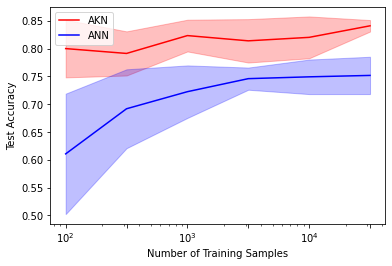

In [41]:
KDE_accs, KDE_stds = np.array(KDE_accs), np.array(KDE_stds)
network_accs, network_stds = np.array(network_accs), np.array(network_stds)
plt.plot(n_ra , KDE_accs, label = "AKN", c = "red")
plt.plot(n_ra, network_accs, label = "ANN", c = "blue")
plt.fill_between(n_ra, KDE_accs + KDE_stds, KDE_accs - KDE_stds, color = "red", alpha = .25)
plt.fill_between(n_ra, network_accs + network_stds, network_accs - network_stds, color = "blue", alpha = .25)
plt.legend()
plt.xlabel("Number of Training Samples")
plt.ylabel("Test Accuracy")
plt.xscale("log")
plt.xticks(n_ra)
plt.show()